In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [4]:


ROOT = Path("/content/drive/MyDrive/samples_segmented_chars/p1_upload_skeletonized")
IMAGE_EXTS = {".png"}

# corner detector params (Shi–Tomasi)
MAX_CORNERS = 256          # cap per image; raise if needed
QUALITY = 0.01             # 0..1; higher = stricter
MIN_DIST = 1               # GFTT built-in suppression distance (px)
BLOCK_SIZE = 3             # window for covariance matrix; 3 is good for thin skeletons
USE_HARRIS = False         # True sometimes helps on bold strokes

# cluster/merge params
# fallback if you don't want size-adaptive: MERGE_EPS_PX = 3
MERGE_EPS_PX_IF_NONE = None  # set to int to fix, or keep None to auto-scale by image size

# debug overlay samples
SAVE_DEBUG_OVERLAY = False
DEBUG_OUT_DIR = Path("/content/corner_debug")
DEBUG_SAMPLE_EVERY = 50  # overlay 1 out of N images

In [5]:
#--- helper ---
def list_images(root: Path):
    for p in root.rglob("*"):
        if p.suffix.lower() in IMAGE_EXTS and p.is_file():
            yield p

def ensure_binary_skeleton(img_gray: np.ndarray) -> np.ndarray:
    """
    Expect already skeletonized images (1-px strokes). If not guaranteed,
    at least binarize safely. We assume foreground is dark on light bg -> invert.
    Returns a binary image with strokes=255, background=0 (what GFTT expects best).
    """
    if img_gray.dtype != np.uint8:
        img_gray = img_gray.astype(np.uint8)
    # Adaptive threshold often safer than fixed for scans
    bw = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 15, 10)
    return bw  # 255 on strokes, 0 bg

def detect_corners_gftt(skel_255: np.ndarray,
                        max_corners=MAX_CORNERS,
                        quality=QUALITY,
                        min_dist=MIN_DIST,
                        block_size=BLOCK_SIZE,
                        use_harris=USE_HARRIS):
    """
    skel_255: binary skeleton (0/255). Returns N x 2 float32 array (x,y).
    """
    # GoodFeaturesToTrack expects 8-bit single channel
    pts = cv2.goodFeaturesToTrack(
        image=skel_255,
        maxCorners=max_corners,
        qualityLevel=quality,
        minDistance=min_dist,
        blockSize=block_size,
        useHarrisDetector=use_harris,
        k=0.04
    )
    if pts is None:
        return np.zeros((0, 2), dtype=np.float32)
    pts = pts.reshape(-1, 2)  # (x, y)
    return pts.astype(np.float32)

def merge_close_points_dbscan(points_xy: np.ndarray, eps_px: float) -> np.ndarray:
    """
    Merge nearby detections into a single corner using DBSCAN.
    Returns cluster centers (mean) as M x 2 float32.
    """
    if points_xy.shape[0] == 0:
        return points_xy
    clustering = DBSCAN(eps=eps_px, min_samples=1, metric='euclidean').fit(points_xy)
    labels = clustering.labels_
    merged = []
    for lab in np.unique(labels):
        merged.append(points_xy[labels == lab].mean(axis=0))
    return np.vstack(merged).astype(np.float32)

def autodetect_merge_eps(h, w, fallback=3):
    # Simple size-aware rule of thumb: ~0.4% of the max dimension, clamped to [2, 6]
    eps = int(round(0.004 * max(h, w)))
    eps = max(2, min(6, eps))
    return eps if MERGE_EPS_PX_IF_NONE is None else MERGE_EPS_PX_IF_NONE

def overlay_points(img_gray: np.ndarray, pts_raw: np.ndarray, pts_merged: np.ndarray) -> np.ndarray:
    """
    Overlay raw (red) and merged (green) points on a BGR preview.
    """
    vis = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    for (x, y) in pts_raw:
        cv2.circle(vis, (int(round(x)), int(round(y))), 3, (0, 0, 255), 1)   # red
    for (x, y) in pts_merged:
        cv2.circle(vis, (int(round(x)), int(round(y))), 3, (0, 255, 0), 1)   # green
    return vis

In [6]:
#--- main funcs ---
def run_corner_stats(root: Path):
    rows = []
    os.makedirs(DEBUG_OUT_DIR, exist_ok=True)

    for i, img_path in enumerate(list_images(root)):
        # load grayscale
        gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if gray is None:
            continue
        H, W = gray.shape[:2]

        # make sure it's binary skeleton 0/255 (white strokes)
        skel255 = ensure_binary_skeleton(gray)  # if already skeleton, this will just binarize/invert

        # detect corners
        pts_raw = detect_corners_gftt(skel255)

        # merge within eps
        eps = autodetect_merge_eps(H, W)
        pts_merged = merge_close_points_dbscan(pts_raw, eps_px=eps)

        # record
        rows.append({
            "file": str(img_path),
            "height": H,
            "width": W,
            "merge_eps_px": eps,
            "corners_raw": int(pts_raw.shape[0]),
            "corners_merged": int(pts_merged.shape[0])
        })

        # optional visual debug
        if SAVE_DEBUG_OVERLAY and (i % DEBUG_SAMPLE_EVERY == 0):
            vis = overlay_points(gray, pts_raw, pts_merged)
            outp = DEBUG_OUT_DIR / f"dbg_{i:05d}.png"
            cv2.imwrite(str(outp), vis)

    df = pd.DataFrame(rows)
    return df


                                                file  height  width  \
0  /content/drive/MyDrive/samples_segmented_chars...      65     36   
1  /content/drive/MyDrive/samples_segmented_chars...      42     45   
2  /content/drive/MyDrive/samples_segmented_chars...      44     32   
3  /content/drive/MyDrive/samples_segmented_chars...      41     31   
4  /content/drive/MyDrive/samples_segmented_chars...      45     24   

   merge_eps_px  corners_raw  corners_merged  
0             2           62              54  
1             2           59              50  
2             2           43              38  
3             2           36              28  
4             2           38              28  

Total images: 3613
Saved: /content/corner_counts.csv


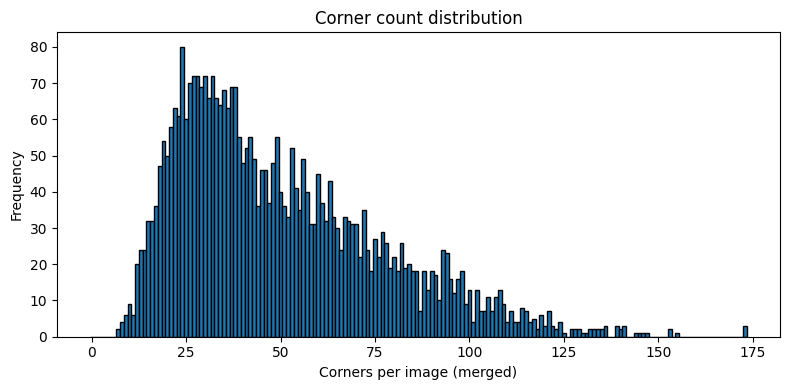

In [7]:
#--- visual data ---
df = run_corner_stats(ROOT)

print(df.head())
print(f"\nTotal images: {len(df)}")

# Save CSV
out_csv = Path("/content/corner_counts.csv")
df.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

# Plot distribution of merged-corner counts
plt.figure(figsize=(8,4))
plt.hist(df["corners_merged"], bins=range(0, df["corners_merged"].max()+2), edgecolor='k', align='left')
plt.xlabel("Corners per image (merged)")
plt.ylabel("Frequency")
plt.title("Corner count distribution")
plt.tight_layout()
plt.show()


Detected corners: 26


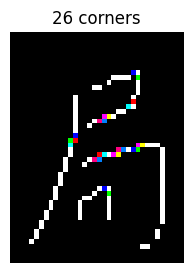

In [20]:
from pathlib import Path
import cv2

# Load and ensure binary (white=255 on black)
img_path = Path("/content/drive/MyDrive/samples_segmented_chars/p1_upload_skeletonized/RC04844/page_1/c200.png")
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
skeleton = (gray > 0).astype(np.uint8) * 255

# Detect corners
corners = detect_junctions(skeleton)
print(f"Detected corners: {len(corners)}")

# Visualize
vis = overlay_color_dots(skeleton, corners)

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"{len(corners)} corners")
plt.axis("off")
plt.show()



In [29]:
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import convolve

# ---------- helpers ----------
NB8 = np.array([[1,1,1],[1,0,1],[1,1,1]], np.uint8)

def ensure_binary_skeleton(gray: np.ndarray) -> np.ndarray:
    """Return 0/255 skeleton with strokes white. If already 0/255, keep (invert if needed)."""
    if gray.dtype != np.uint8: gray = gray.astype(np.uint8)
    u = set(np.unique(gray).tolist())
    if u.issubset({0,255}):
        return gray if np.mean(gray) < 127 else cv2.bitwise_not(gray)
    # fallback binarization
    _, bw = cv2.threshold(255 - gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return bw

def degree8(B01):  # count 8-neighbors
    return convolve(B01, NB8, mode='constant')

def connected_components(mask01):
    num, lab = cv2.connectedComponents(mask01.astype(np.uint8), connectivity=8)
    return num, lab

# ---------- graph extraction: nodes (junctions & endpoints), paths between nodes ----------
def extract_graph(B255):
    B01 = (B255 > 0).astype(np.uint8)
    H, W = B01.shape
    deg = degree8(B01)

    is_junc = (B01==1) & (deg >= 3)
    is_end  = (B01==1) & (deg == 1)
    is_node = (B01==1) & (deg != 2)

    # collapse adjacent junction pixels -> one centroid each
    nj, lab_j = connected_components(is_junc)
    junc = []
    for lid in range(1, nj):
        ys, xs = np.where(lab_j == lid)
        junc.append((int(round(xs.mean())), int(round(ys.mean()))))
    junc = np.array(junc, dtype=np.int32) if junc else np.zeros((0,2), np.int32)

    # endpoints (collapse as well)
    ne, lab_e = connected_components(is_end)
    ends = []
    for lid in range(1, ne):
        ys, xs = np.where(lab_e == lid)
        ends.append((int(round(xs.mean())), int(round(ys.mean()))))
    ends = np.array(ends, dtype=np.int32) if ends else np.zeros((0,2), np.int32)

    # neighbor generator
    def nbrs(y,x):
        for dy,dx in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
            ny, nx = y+dy, x+dx
            if 0<=ny<H and 0<=nx<W and B01[ny,nx]==1:
                yield ny, nx

    node_pix = set(map(tuple, np.argwhere(is_node)))
    deg_arr = deg
    paths = []
    seen_edges = set()

    for (ny, nx) in node_pix:
        for (py, px) in list(nbrs(ny, nx)):
            ekey = tuple(sorted([(ny,nx),(py,px)]))
            if ekey in seen_edges:
                continue
            path = [(nx, ny)]  # (x,y)
            prev = (ny, nx); curr = (py, px)
            seen_edges.add(ekey)
            while True:
                path.append((curr[1], curr[0]))
                if deg_arr[curr] != 2:
                    break
                nxts = [q for q in nbrs(*curr) if q != prev]
                if not nxts: break
                nxt = nxts[0]
                seen_edges.add(tuple(sorted([curr, nxt])))
                prev, curr = curr, nxt
            paths.append(np.array(path, dtype=np.int32))

    return junc, ends, paths

# ---------- chain-code corner detection on paths (suppresses aliasing) ----------
STEP8 = np.array([[1,0],[1,1],[0,1],[-1,1],[-1,0],[-1,-1],[0,-1],[1,-1]], dtype=int)

def chain_codes(poly: np.ndarray) -> np.ndarray:
    d = poly[1:] - poly[:-1]
    codes = np.empty(len(d), dtype=int)
    for i,(dx,dy) in enumerate(d):
        if dx==0 and dy==0: codes[i]=0; continue
        sx = 0 if dx==0 else (1 if dx>0 else -1)
        sy = 0 if dy==0 else (1 if dy>0 else -1)
        step = np.array([sx,sy])
        for c in range(8):
            if (STEP8[c] == step).all():
                codes[i]=c; break
    return codes

def circular_mode_filter(codes: np.ndarray, w:int=5) -> np.ndarray:
    if len(codes)==0: return codes
    k = max(1, w//2)
    out = codes.copy()
    for i in range(len(codes)):
        a = max(0, i-k); b = min(len(codes), i+k+1)
        vals, cnts = np.unique(codes[a:b], return_counts=True)
        out[i] = vals[np.argmax(cnts)]
    return out

def compress_runs(codes: np.ndarray):
    if len(codes)==0: return np.array([0]), np.array([len(codes)]), np.array([0])
    starts=[0]; dirs=[codes[0]]
    for i in range(1,len(codes)):
        if codes[i]!=codes[i-1]:
            starts.append(i); dirs.append(codes[i])
    starts = np.array(starts, int)
    lens = np.diff(np.append(starts, len(codes)))
    dirs = np.array(dirs, int)
    return starts, lens, dirs

def dir_delta(a:int, b:int) -> int:  # 0..4 (steps of 45°)
    d = abs(a-b)%8
    return min(d, 8-d)

def detect_path_corners_chain(path: np.ndarray,
                              dir_window:int=7, min_run_px:int=6,
                              theta_steps:int=4, nms_sep:int=6) -> list:
    """
    Return list of (x,y) corner points on a single path.
    - dir_window: majority filter on direction codes (smooth jaggies)
    - min_run_px: require at least this many pixels straight on each side
    - theta_steps: direction change threshold in 45° steps (4≈90°, 3≈67.5°)
    - nms_sep: minimal separation along path indices
    """
    if len(path) < (min_run_px*2 + 2): return []
    codes = chain_codes(path)
    codes_s = circular_mode_filter(codes, w=dir_window)
    starts, lens, dirs = compress_runs(codes_s)

    idx_candidates = []
    for r in range(1, len(starts)):
        L = lens[r-1]; R = lens[r]
        if L < min_run_px or R < min_run_px: continue
        if dir_delta(dirs[r-1], dirs[r]) >= theta_steps:
            idx_candidates.append(starts[r])

    idx_candidates.sort()
    kept = []
    last = -10**9
    for i in idx_candidates:
        if i - last >= nms_sep:
            kept.append(i); last = i

    return [tuple(path[i]) for i in kept]

def detect_bend_corners_on_paths(paths,
                                 dir_window=7, min_run_px=6,
                                 theta_steps=4, nms_sep=6):
    pts=[]
    for P in paths:
        pts.extend(detect_path_corners_chain(P, dir_window, min_run_px, theta_steps, nms_sep))
    return np.array(pts, np.int32) if pts else np.zeros((0,2), np.int32)

# ---------- visualization ----------
def overlay_dots(skel255, pts, color):
    vis = cv2.cvtColor(skel255, cv2.COLOR_GRAY2BGR)
    for (x,y) in pts:
        vis[y, x] = color  # 1‑px colored dot
    return vis

def show_corners_single(gray,
                        dir_window=7, min_run_px=6,
                        theta_steps=4, nms_sep=6):
    skel = ensure_binary_skeleton(gray)
    junc, ends, paths = extract_graph(skel)
    bend = detect_bend_corners_on_paths(paths, dir_window, min_run_px, theta_steps, nms_sep)

    vis = cv2.cvtColor(skel, cv2.COLOR_GRAY2BGR)
    for (x,y) in junc: vis[y,x] = (255, 0,255)  # magenta junctions
    for (x,y) in bend: vis[y,x] = (0,255,255)   # cyan bends

    total = len(junc) + len(bend)
    plt.figure(figsize=(4,5))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"{total} corners")
    plt.axis('off'); plt.show()

    print(f"junctions: {len(junc)} | bends: {len(bend)} | total: {total}")
    return junc, bend, vis


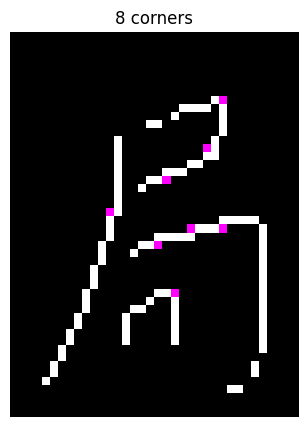

junctions: 8 | bends: 0 | total: 8


In [30]:
img_path = Path("/content/drive/MyDrive/samples_segmented_chars/p1_upload_skeletonized/RC04844/page_1/c200.png")
gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
junc, bend, vis = show_corners_single(
    gray,
    dir_window=7,   # ↑ for more smoothing of stair-steps
    min_run_px=6,   # ↑ to require longer straight segments
    theta_steps=4,  # 4≈90°; 3≈67.5°. Raise to be stricter.
    nms_sep=6       # ↑ to suppress very close duplicates
)


In [ ]:
import pandas as pd

ROOT = Path("/content/drive/MyDrive/samples_segmented_chars/p1_upload_skeletonized/")
OUT  = Path("/content/drive/MyDrive/samples_segmented_chars/skeleton_corner_overlays/"); OUT.mkdir(parents=True, exist_ok=True)
exts = {".png"}

rows = []
for p in ROOT.rglob("*"):
    if p.suffix.lower() not in exts: continue
    g = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if g is None: continue
    junc, bend, vis = show_corners_single(g, dir_window=7, min_run_px=6, theta_steps=4, nms_sep=6)
    cv2.imwrite(str(OUT / (p.stem + "_corners.png"+f"_c{len(junc)+len(bend)}")), vis)
    rows.append({"file": str(p), "junctions": len(junc), "bends": len(bend), "total": len(junc)+len(bend)})

df = pd.DataFrame(rows)
df.to_csv(OUT / "corner_counts.csv", index=False)
#print("Saved:", OUT)